In [2]:
!pip install sentence-transformers --quiet
!pip install --index-url https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.7 MB/s eta 0:00:00


In [8]:
import pandas as pd
import requests
from io import StringIO

# GitHub checks
github_csv_url = "https://raw.githubusercontent.com/BalaramUOA/TextGenAI/main/data/survey_insurance.csv"

# Fetching CSV data from GitHub
response = requests.get(github_csv_url)

# Checking if the request was successful
if response.status_code == 200:
    # Reading CSV data
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data, header=0)
    # Now df contains the data from the CSV file
    print(df.head())  # Displaying the first few rows of the DataFrame
else:
    print("Failed to fetch data from GitHub.")


  Customer_id                                          responses  nps
0        c001  The insurance claim process was smooth, and th...    9
1        c002  I'm disappointed with the high premiums charge...    4
2        c003  The insurance agent provided valuable insights...    8
3        c004  I regret purchasing an insurance policy with l...    3
4        c005  Applying for insurance online was convenient, ...    8


###**Following  steps are followed in the code below**


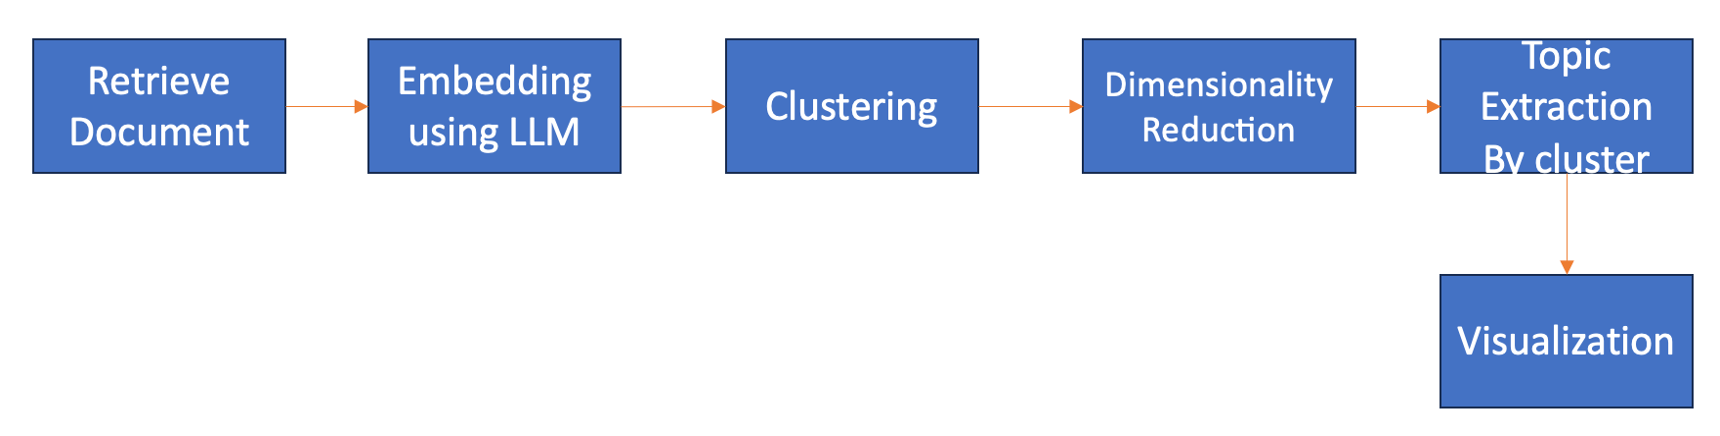

## Following code is a great visual to represents cluster distribution and topics; that will create more intutive visuals like follow.
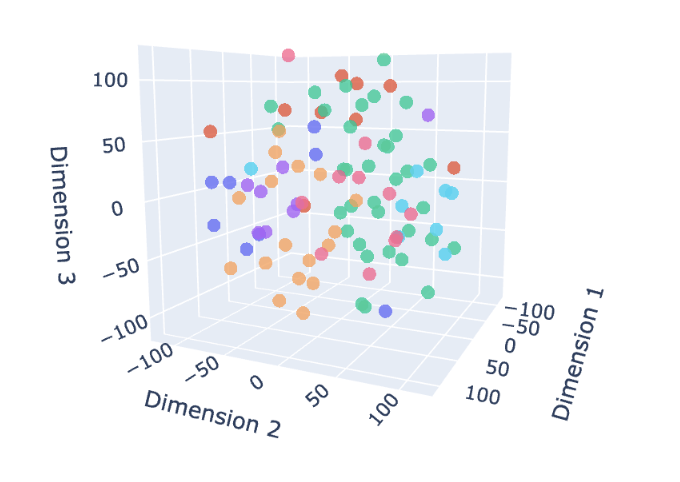

In [10]:
# df

In [12]:
import pandas as pd
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objs as go
import requests
from io import StringIO

documents = df['responses']

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the documents
document_embeddings = model.encode(documents)

# Fit KMeans clustering
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(document_embeddings)

# Dimensionality reduction for visualization
tsne = TSNE(n_components=3, random_state=42)
vectors_tsne = tsne.fit_transform(document_embeddings)

# Topic modeling using LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)
lda = LatentDirichletAllocation(n_components=num_clusters, random_state=42)
lda.fit(X)

# Extract top topic for each cluster
top_topics_per_cluster = []
feature_names = vectorizer.get_feature_names_out()
for cluster_id in range(num_clusters):
    cluster_mask = (cluster_ids == cluster_id)
    cluster_documents = documents[cluster_mask]
    X_cluster = vectorizer.transform(cluster_documents)
    topic_distribution = lda.transform(X_cluster)
    top_topic_idx = np.argmax(topic_distribution, axis=1)
    top_topic_words_idx = np.argsort(lda.components_[top_topic_idx[0]])[::-1][:10]
    top_topic_words = [feature_names[i] for i in top_topic_words_idx]
    top_topics_per_cluster.append(', '.join(top_topic_words))

# Create trace for each cluster
traces = []
for cluster_id in range(num_clusters):
    cluster_mask = (cluster_ids == cluster_id)
    trace = go.Scatter3d(
        x=vectors_tsne[cluster_mask, 0],
        y=vectors_tsne[cluster_mask, 1],
        z=vectors_tsne[cluster_mask, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
        ),
        name=f'Cluster {cluster_id}',
        hoverinfo='text',
        text=f'Topics: {top_topics_per_cluster[cluster_id]}'
    )
    traces.append(trace)

# Create layout
layout = go.Layout(
    title='Visualization of text response cluster and topics associated',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3'),
    ),
    hovermode='closest',
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

